# Force/Distance Curves
## Fitting parameters for dsDNA
In this first section we're going to use pylake to get force and distance data for a single strande of lambda dsDNA

The below loaded experiment is a measurement of forces of a DNA tether that has some nucleosomes on it, which is then stretched and relaxed repeatedly until the nucleosomes have fallen off

We are going to start by looking at the third stretch done on this molecule where there should be no nucleosomes remaining

For starters, let's open the file and look at the downsampled force during the course of the multiple stretches

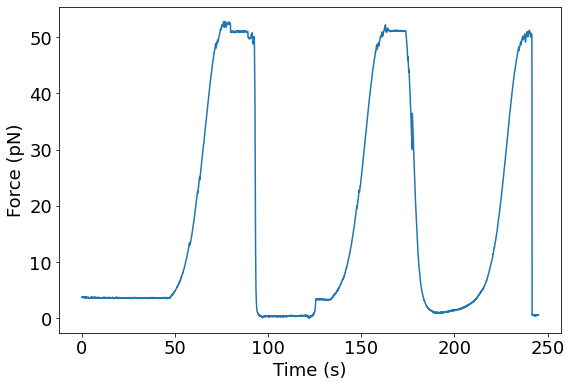

In [14]:
import matplotlib.pyplot as plt
import lumicks.pylake as lk

%matplotlib inline

file = lk.File('chromatin_dna.h5')

force = file.downsampled_force2.data
time = file.downsampled_force2.timestamps

plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (9, 6)

plt.plot((time-time[0])/1e9, force)
plt.ylabel('Force (pN)')
plt.xlabel('Time (s)')
plt.show()

If you zoom around the above trace you will notice some ruptures that occur in the first two stretches, those are individual nucleosomes being popped off when the DNA is stretched out.

To more easily navigate the plot you can switch to the matplotlib widget instead of inline mode above:
`%matplotlib widget` if it is available and working on your machine

Next we will select the final stretch where it's only DNA using some time slicing that is available within pylake. The time stamps for that slice are in the code below. We will refer to that stretch as "s3"

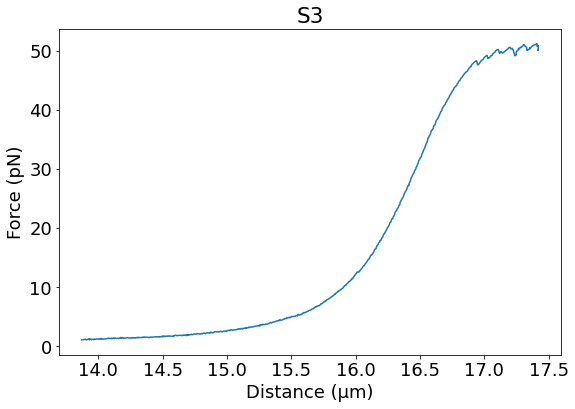

In [15]:
s3_t1 = '195s'
s3_t2 = '241s'

s3_force = file.downsampled_force2[s3_t1:s3_t2].data
s3_distance = file.distance1[s3_t1:s3_t2].data

plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (9, 6)

plt.plot(s3_distance, s3_force)
plt.ylabel('Force (pN)')
plt.xlabel('Distance (µm)')
plt.title('S3')
plt.show()

As you can see, as the forces approach 50 pN the curve starts running away as the DNA is beginning to be unwound. This twisting force can be accounted for in the various models that we will be fitting to this data but we'll start with a simpler version and filter out some of that data.

The models available for fitting using pylake can be found [here](https://lumicks-pylake.readthedocs.io/en/stable/api.html#fd-models) and the references to those models are listed [here](https://lumicks-pylake.readthedocs.io/en/stable/zrefs.html)

Next we are going to fit a simple model to this data that will only look at forces < 30 pN, the extensible worm-like chain model (the Odijk model)

We are going to invoke the model by itself below to look at the equation before we fit its parameters.

In [16]:
lk.odijk('DNA')

Name,Value,Unit,Fitted,Lower bound,Upper bound
DNA/Lp,40,[nm],True,0,100
DNA/Lc,16,[micron],True,0,inf
DNA/St,1500,[pN],True,0,inf
kT,4.11,[pN*nm],False,0,8


As you can see, the output of any of the implemented models in pylake includes useful information like the references, the parameters and their starting values, as well as the equation that will be used for the fitting. Note how kT is a constant and thus fitting of that value is disabled. This can be performed for any of the parameters.

The extensible worm-like chain model is briefly talked about in [this Wikipedia article](https://en.wikipedia.org/wiki/Worm-like_chain#Extensible_worm-like_chain_model) and the parameters that we see here represent the following:
* $Lp$ is the persistence length of the polymer
* $Lc$ is the contour length of the polymer
* $St$ is an elastic modulus that accounts for the stretching of the polymer

In our experiment we are actively changing the distance and measuring out the force so we will actually need an inverse of the above equation where the force is the dependent. You can invert the models in pylake, but for speed purposes, some models already exist in an inverted solution and is what we'll be doing for our fitting:

In [4]:
lk.inverted_odijk('DNA').subtract_independent_offset() + lk.force_offset('DNA')

Name,Value,Unit,Fitted,Lower bound,Upper bound
DNA/d_offset,0.01,[au],True,-0.1,0.1
DNA/Lp,40,[nm],True,0,100
DNA/Lc,16,[micron],True,0,inf
DNA/St,1500,[pN],True,0,inf
kT,4.11,[pN*nm],False,0,8
DNA/f_offset,0.01,[pN],True,-0.1,0.1


Note how above I also added two offset parameters for our two variables in case the force wasn't zeroed correctly or the bead-to-bead distance is miscalculated due to a bead size inaccuracy.

Below we are creating our model and our fitting object. The object then gets the data that we will fit the model to and fitting is initiated. Note how we are only using data where the force is less than 30 pN which is where the Odijk solution works.

In [17]:
bare_dna_model = lk.inverted_odijk('DNA').subtract_independent_offset() + lk.force_offset('DNA')
bare_dna_fit = lk.FdFit(bare_dna_model)
bare_dna_fit.add_data('s3', s3_force[s3_force<30], s3_distance[s3_force<30])
bare_dna_fit.fit()

Name,Value,Unit,Fitted,Lower bound,Upper bound
DNA/d_offset,0.0100107,[au],True,-0.1,0.1
DNA/Lp,42.4047,[nm],True,0,100
DNA/Lc,16.6172,[micron],True,0,inf
DNA/St,1621.65,[pN],True,0,inf
kT,4.11,[pN*nm],False,0,8
DNA/f_offset,0.1,[pN],True,-0.1,0.1


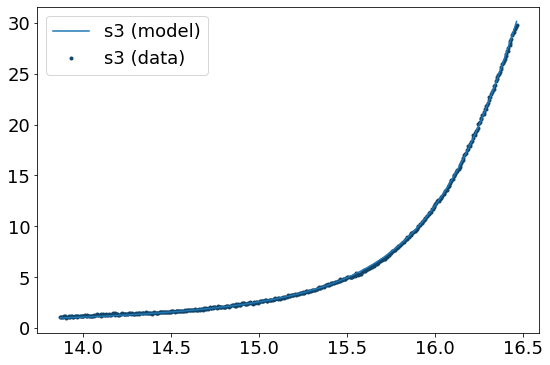

In [18]:
bare_dna_fit.plot()

As you can see the model with its fitted parameters fits our data quite nicely in this regime. And the parameters that the fitting arrived at look reasonable given what we know about our system here.

## Fitting parameters for chromatin
For the next exercise you will have time to do some fitting on your own using the above code.

Please select the data from the first stretch in the experiment, s1, and use it to fit a model. This stretch had nucleosomes on the DNA, did this affect how the polymer behaved? The times for slicing this first stretch are provided below.

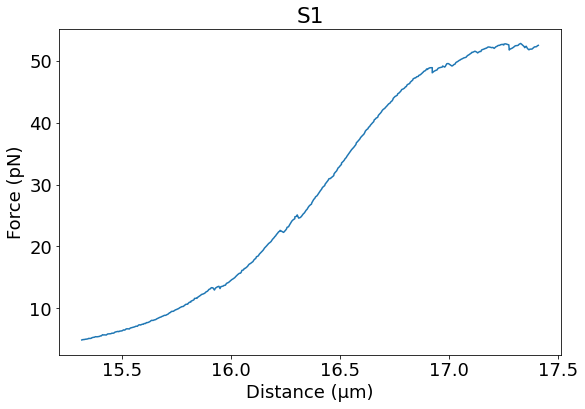

In [21]:
s1_t1 = '50s'
s1_t2 = '78s'

s1_force = file.downsampled_force2[s1_t1:s1_t2].data
s1_distance = file.distance1[s1_t1:s1_t2].data

plt.plot(s1_distance, s1_force)
plt.ylabel('Force (pN)')
plt.xlabel('Distance (µm)')
plt.title('S1')
plt.show()

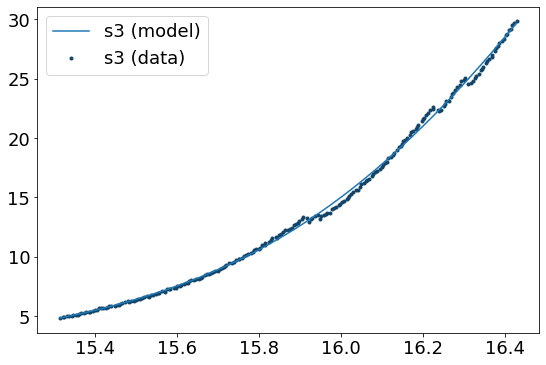

In [22]:
# Your code
chrom_model = lk.inverted_odijk('DNA').subtract_independent_offset() + lk.force_offset('DNA')
chrom_fit = lk.FdFit(bare_dna_model)
chrom_fit.add_data('s3', s1_force[s1_force<30], s1_distance[s1_force<30])
chrom_fit.fit()
chrom_fit.plot()

**What if we only fit the model before the first nucleosome rupture?**

Hint: rupture occurs shortly after 15.9 µm

In [9]:
# Your code
chrom_model = lk.inverted_odijk('DNA').subtract_independent_offset() + lk.force_offset('DNA')
chrom_fit = lk.FdFit(bare_dna_model)
chrom_fit.add_data('s3', s1_force[s1_force<30], s1_distance[s1_force<30])
chrom_fit.fit()
chrom_fit.plot()

**Split the chromatin trace (s1) into two seperate extension curves to see the difference between contour lengths**

In [10]:
# Your code

## Fitting parameters for ssDNA
For the next exercise you are to fit a model to single stranded DNA stretching data, provided in the cell below.

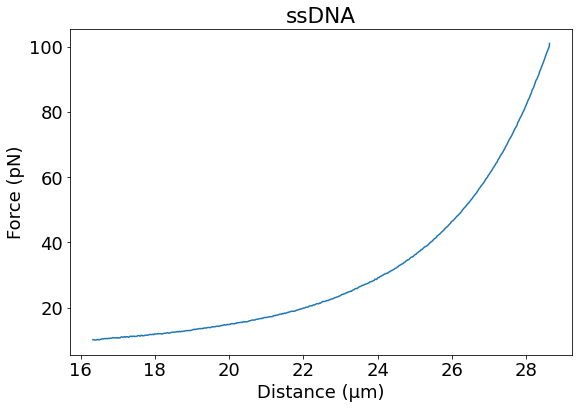

In [20]:
ssfile = lk.File('ssdna.h5')
ss_t2 = '29.75s'
ss_force = ssfile.downsampled_force2[:ss_t2].data
ss_distance = ssfile.distance1[:ss_t2].data

plt.plot(ss_distance, ss_force)
plt.ylabel('Force (pN)')
plt.xlabel('Distance (µm)')
plt.title('ssDNA')
plt.show()

**Now try out various models and see what sort of parameters you get for ssDNA.**

Reminder, models available can be found [here](https://lumicks-pylake.readthedocs.io/en/stable/api.html#fd-models) and the references to those models are listed [here](https://lumicks-pylake.readthedocs.io/en/stable/zrefs.html)

In [12]:
# Your code

**Do the ssDNA parameters make sense?**

## Fitting twisting models for dsDNA
**Try using the bare DNA data from above (s3) to fit a model with twisting in pylake.**